In [1]:
import ray
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

from gym.spaces import Discrete
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair, Instrument
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

import ray.rllib.agents.ppo as ppo

In [2]:
BRL = Instrument("BRL", 2, "Brazilian Currency")
ASSET = Instrument("ASSET", 2, "Asset")

In [3]:
class BSH(TensorTradeActionScheme):
    """The ActionScheme interprets and applies the agent’s actions to the environment."""

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self,
                   action: int,
                   portfolio: 'Portfolio'):
        
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash

            if src == self.cash:
                # Calculates proportional order size (n lots of 100 shares)
                lot_size = 100.00
                current_price = float(portfolio.exchange_pairs[0].price)
                source_balance = src.balance.as_float()

                qtd_assets = source_balance / (lot_size * current_price)

                num_shares = int(qtd_assets - (qtd_assets % 10) - 1) * lot_size

                proportional_lot_size = (num_shares * current_price) / source_balance
            else:
                proportional_lot_size = 1.0

#             print('--' * 50)
#             if src == self.cash:
#                 print ('CASH TO ASSET')
#                 print('Source Balance: ', src.balance.as_float())
#                 print('Target Balance: ', tgt.balance.as_float())
#                 print('Proportional Lot Size', proportional_lot_size)
#                 print('Current Price: ', float(portfolio.exchange_pairs[0].price))
#                 print('# Shares: ', num_shares)
#                 print('Current Price x # Shares: ', num_shares * float(portfolio.exchange_pairs[0].price))
#             else:
#                 print ('ASSET TO CASH')
#                 print('Source Balance: ', src.balance.as_float())
#                 print('Target Balance: ', tgt.balance.as_float())
#                 print('Proportional Lot Size', proportional_lot_size)

#             print('--' * 50)

            order = proportion_order(portfolio, src, tgt, proportional_lot_size)

            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [4]:
class PBR(TensorTradeRewardScheme):

    """ Position-based reward scheme (PBR).
    
    The RewardScheme computes the reward for 
    each time step based on the agent’s performance.
    """
    
    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [5]:
class PositionChangeChart(Renderer):
    """The Renderer renders a view of the environment and interactions."""
    
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        # The Observer generates the next observation for the agent.
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="v", color="red") # BUY
        axs[0].scatter(sell.index, sell.values, marker="^", color="green") # SELL
        axs[0].set_title("Trading Chart")
        axs[0].legend(['Price', 'Buys', 'Sells'])

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

---

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [6]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    ticker = 'PETR4'

    # PRICES
    y = yf.download(f'{ticker}.SA', start='2021-01-01', end='2022-01-01')['Adj Close'].dropna().values
    p = Stream.source(y, dtype="float").rename("BRL-ASSET")
    
    b3 = Exchange("B3", service=execute_order)(p)

    # Portfolio
    cash = Wallet(b3, 100000 * BRL) # Money
    asset = Wallet(b3, 0 * ASSET) # Stocks
    
    portfolio = Portfolio(BRL, [cash, asset])

    # Data
    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])
    
    # Reward
    reward_scheme = PBR(
        price=p
    )
    
    # Actions
    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(yf.download(f'{ticker}.SA', start='2021-01-01', end='2022-01-01').index)).rename("date"),
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    # Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [25]:
window_size = 20

analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 2.5
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": window_size
        },
        "log_level": "DEBUG",
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

Trial name,status,loc
PPO_TradingEnv_de6af_00000,PENDING,


2022-04-22 14:23:04,978	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=39976) 2022-04-22 14:23:14,882	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=39972) 2022-04-22 14:23:20,600	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=39972) 2022-04-22 14:23:20,664	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=39972) 2022-04-22 14:23:20,671	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000001F4F7712130>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=39972)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=39972)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=39972)  [-inf -inf -inf -inf

RayTaskError(RayOutOfMemoryError): [36mray::PPO.get_auto_filled_metrics()[39m (pid=39976, ip=127.0.0.1, repr=PPO)
  File "python\ray\_raylet.pyx", line 585, in ray._raylet.execute_task
  File "C:\Users\mathe\anaconda3\envs\tf\lib\site-packages\ray\_private\memory_monitor.py", line 156, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-625611C is used (15.82 / 15.86 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
16600	3.13GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe -m ipykernel_launcher --ip=127.0.0.1 --stdin=9014 --cont
1776	1.96GiB	C:\Users\mathe\AppData\Local\Programs\Microsoft VS Code\Code.exe --type=renderer --user-data-dir=C:\
39972	1.36GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe C:\Users\mathe\anaconda3\envs\tf\lib\site-packages\ray\w
19044	1.05GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe C:\Users\mathe\anaconda3\envs\tf\lib\site-packages\ray\w
39976	0.79GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe C:\Users\mathe\anaconda3\envs\tf\lib\site-packages\ray\w
36580	0.45GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe -m ipykernel_launcher --ip=127.0.0.1 --stdin=9019 --cont
16340	0.28GiB	C:\Users\mathe\AppData\Local\Programs\Microsoft VS Code\Code.exe --type=renderer --user-data-dir=C:\
17216	0.2GiB	C:\Users\mathe\AppData\Local\Programs\Microsoft VS Code\Code.exe --ms-enable-electron-run-as-node c:
13716	0.16GiB	C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe --no-startup-window --win-session-start
10024	0.13GiB	C:\Users\mathe\AppData\Local\Programs\Microsoft VS Code\Code.exe --ms-enable-electron-run-as-node c:

In addition, up to 0.0 GiB of shared memory is currently being used by the Ray object store.
---
--- Tip: Use the `ray memory` command to list active objects in the cluster.
--- To disable OOM exceptions, set RAY_DISABLE_MEMORY_MONITOR=1.
---

 pid=39976) 2022-04-22 14:23:26,660	ERROR worker.py:84 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::RolloutWorker.set_weights() (pid=39972, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001F4F4E70F40>)
 pid=39976)   File "python\ray\_raylet.pyx", line 585, in ray._raylet.execute_task
 pid=39976)   File "C:\Users\mathe\anaconda3\envs\tf\lib\site-packages\ray\_private\memory_monitor.py", line 156, in raise_if_low_memory
 pid=39976)     raise RayOutOfMemoryError(
 pid=39976) ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-625611C is used (15.82 / 15.86 GB). The top 10 memory consumers are:
 pid=39976) 
 pid=39976) PID	MEM	COMMAND
 pid=39976) 16600	3.13GiB	C:\Users\mathe\anaconda3\envs\tf\python.exe -m ipykernel_launcher --ip=127.0.0.1 --stdin=9014 --cont
 pid=39976) 1776	1.96GiB	C:\Users\mathe\AppData\Local\Programs\Microsoft VS Code\Code.exe --type=renderer --user-data-dir=C:\
 p

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [8]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": window_size # We want to look at the last x samples (days)
        },
        "framework": "tf2",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

2022-04-22 11:58:10,310	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


[*********************100%***********************]  1 of 1 completed


 pid=19044) 2022-04-22 11:58:18,206	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)


[*********************100%***********************]  1 of 1 completed


 pid=19044) 2022-04-22 11:58:19,247	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=19044) 2022-04-22 11:58:19,334	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000001C25CC089D0>: Box([[-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -inf -inf -inf]
 pid=19044)  [-inf -inf -i

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


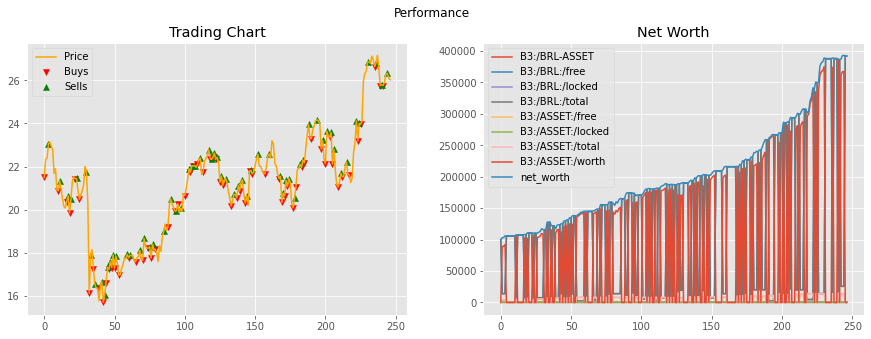

In [9]:
# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

---

### Validation Set (Out-of-Sampe Data)

[*********************100%***********************]  1 of 1 completed


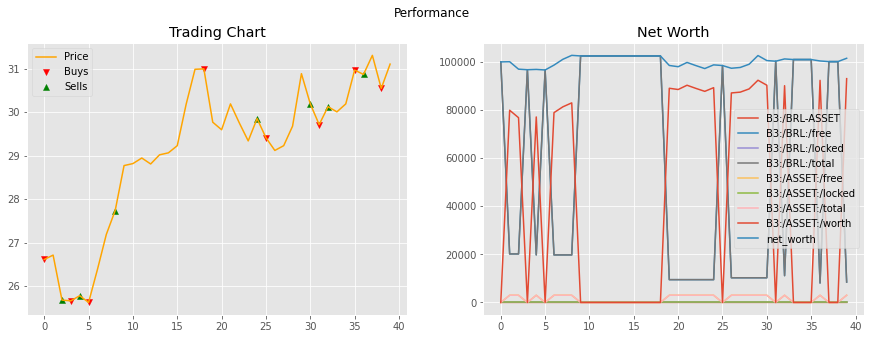

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),79830.00 BRL,20170.00 BRL,79830.00 BRL,79830.00 BRL
1,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),239.49 BRL,20170.00 BRL,79590.51 BRL,79590.51 BRL
2,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),79590.51 BRL,20170.00 BRL,0.00 BRL,0.00 BRL
3,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3,B3:ASSET/locked,DEPOSIT (TRADED 79590.51 BRL B3:BRL/ASSET @ 26...,2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
4,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),0.00 BRL,20170.00 BRL,0.00 BRL,0.00 BRL
5,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:ASSET/locked,B3:ASSET/free,UNLOCK ASSET (COMPLETED),2991.00 ASSET,2991.00 ASSET,0.00 ASSET,0.00 ASSET
6,4af8565d-51bd-4696-9b84-98645a27f003,3,B3:ASSET/free,B3:ASSET/locked,LOCK (LOCK FOR ORDER),2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
7,4af8565d-51bd-4696-9b84-98645a27f003,3,B3:ASSET/locked,B3,WITHDRAWAL (COMMISSION),8.97 ASSET,0.00 ASSET,2982.03 ASSET,2982.03 ASSET
8,4af8565d-51bd-4696-9b84-98645a27f003,3,B3:ASSET/locked,B3,WITHDRAWAL (FILL ORDER),2982.03 ASSET,0.00 ASSET,0.00 ASSET,0.00 ASSET
9,4af8565d-51bd-4696-9b84-98645a27f003,3,B3,B3:BRL/locked,DEPOSIT (TRADED 2982.03 ASSET B3:BRL/ASSET @ 2...,76578.53 BRL,20170.00 BRL,76578.53 BRL,76578.53 BRL


In [10]:
def create_eval_env(config):
    y = config["y"]
    
    p = Stream.source(y, dtype="float").rename("BRL-ASSET")

    b3 = Exchange("B3", service=execute_order)(p)

    cash = Wallet(b3, 100000 * BRL)
    asset = Wallet(b3, 0 * ASSET)

    portfolio = Portfolio(BRL, [cash, asset])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment, portfolio


# Instantiate the environment
env, portfolio = create_eval_env({
    "window_size": window_size,
    "y": yf.download(f'PETR4.SA', start='2022-01-02', end='2022-03-01')['Adj Close'].dropna().values
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

---

In [11]:
pd.set_option('display.max_colwidth', None)

In [16]:
portfolio.ledger.as_frame().head()

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),79830.00 BRL,20170.00 BRL,79830.00 BRL,79830.00 BRL
1,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),239.49 BRL,20170.00 BRL,79590.51 BRL,79590.51 BRL
2,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),79590.51 BRL,20170.00 BRL,0.00 BRL,0.00 BRL
3,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3,B3:ASSET/locked,DEPOSIT (TRADED 79590.51 BRL B3:BRL/ASSET @ 26.61),2991.00 ASSET,0.00 ASSET,2991.00 ASSET,2991.00 ASSET
4,b18c2607-7b94-4a8c-86c8-34c0df2e3f73,1,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),0.00 BRL,20170.00 BRL,0.00 BRL,0.00 BRL


(pid=None) [2022-04-22 14:08:00,441 C 38628 39324] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8247328359524230500
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
 pid=28164) 2022-04-22 14:08:11,520	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=28164) 2022-04-22 14:08:21,420	ERROR worker.py:431 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::PPO.__init__() (pid=28164, ip=127.0.0.1)
 pid=28164)   File "python\ray\_raylet.pyx", line 625, in ray._raylet.execute_task
 pid=28164)   File "python\ray\_raylet.pyx", line 629, in ray._raylet.execut

In [13]:
df = pd.DataFrame(portfolio.performance)

new_column_list = list(yf.download(f'PETR4.SA', start='2022-01-02', end='2022-03-01').index.astype(str).values)

assert len(new_column_list) == df.shape[1]

df.set_axis(new_column_list, axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [23]:
def plot_evaluation_results(df):
    """Plot Evaluation Set Results."""
    fig, ax = plt.subplots(3, sharex=True, figsize=(15,6))
    
    # Net Worth
    df.loc["net_worth"].plot(ax=ax[0])
    ax[0].set_title('Net Worth')
    ax[0].set_ylabel("Cash (R$)")
    #ax[0].set_xlabel("Valores em X")
    ax[0].axhline(100000, linestyle='dashed', color='black')
    ax[0].legend(['Current Net Worth', 'Initial Net Worth'])
    
    # Asset Price
    df.loc["B3:/BRL-ASSET"].plot(ax=ax[1])
    ax[1].set_title('Asset Price')
    ax[1].set_ylabel("Price (R$)")
    ax[1].legend(['Current Share Price'])
    
    # Positions
    df.loc["B3:/ASSET:/total"].plot(ax=ax[2])
    ax[2].set_title('Positions')
    ax[2].set_ylabel("Shares (#)")
    ax[2].set_xlabel("Datetime")
    ax[2].legend(['Current Position'])
    
    plt.tight_layout()

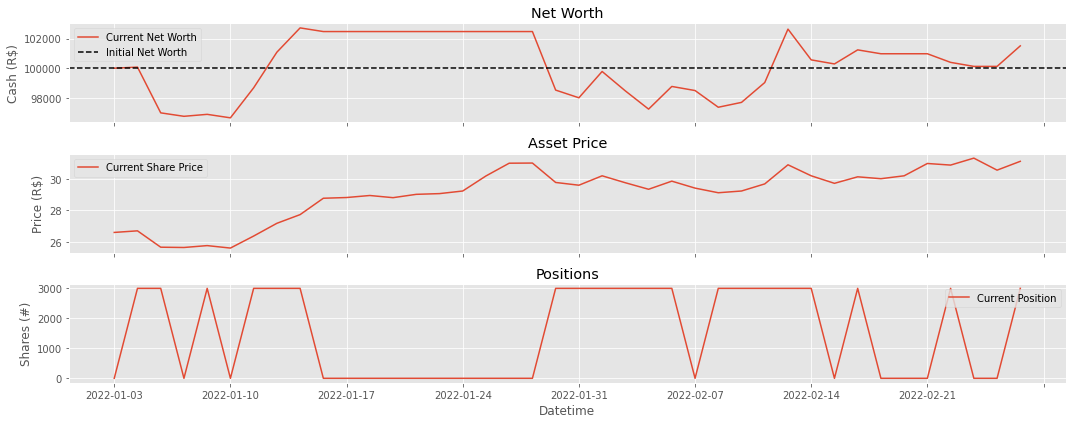

In [24]:
plot_evaluation_results(df)

---